# CloudCatalog (feat. CDAWeb/SDO/MMS/User data)

Sandy Antunes (sandy.antunes@jhuapl.edu), https://github.com/heliocloud-data/cloudcatalog

`pip install cloudcatalog`

## Overall
* CloudCatalog is a PyHC package (`import cloudcatalog`)
* Used for 1PB+ of HelioCloud data (CDAWeb, SDO, MMS, EUV-ML, others)
* HAPI-like: id + start + stop -> filelists
* Allows self-publishing of data for Open Science

## For data owners/publishers:
* like HAPI, it is both a specification and an accompanying Python API
* decentralized (data owners control their data)
* simply creates a shareable and searchable index.

## Behind the curtain
* top-level JSON + CSV indices
* serverless, lightweight
* works for AWS S3 or conventional hosting (HTTP or HTTPS URLs)

Bonus: tell HDRL about your top-level JSON file and your data is now indexed and findable by anyone using CloudCatalog.

## Future
* add hooks to PySpedas & HAPI?
* tools for users to self-publish more easily and be index
* integrate with VSO
* cross-link with ESA DataLabs

In [39]:
import astropy.io.fits
import cdflib
import matplotlib.pyplot as plt

In [40]:
import cloudcatalog

# Cloud Catalog Demo

The CloudCatalog specification and accompanying Python client and demo notebook are a method for efficiently getting a list of data files stored in AWS S3 that are publicly accessible to scientists.  In addition to querying which datasets are available, users can directly retrieve the list of files in the form of 'start_time, stop_time, file key, filesize' as a Pandas DataFrame.

We jump into a quick demo of fetching a day's worth of MMS1 files.  We then step back to show how to query the 'catalog of catalogs' to explore and find datasets.  We close with a more extended MMS demo that fetches the list of files then plots them directly from cloud storage (no intermediate file transfers needed).


In [44]:
# micro demo
import cloudcatalog
fr=cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")
frID = "aia_0094"
myjson = fr.get_entry(frID)
start, stop = myjson['start'], myjson['stop']
file_registry1 = fr.request_cloud_catalog(frID, start_date=start, stop_date=stop)
print(f"Found {len(file_registry1)} files for id {frID} over span {start} to {stop}")

Found 1496151 files for id aia_0094 over span 2010-05-13T00:00:00Z to 2022-12-31T23:56:00Z


## Setup
The file catalog API is just "import cloudcatalog".  You also set a variable to point to where the global catalog of all known storage buckets (AWS S3 buckets) exist.  This is an index catalog that points to, basically, all known HelioClouds.

In [23]:
import cloudcatalog

# HAPI-like queries

We will start with the main usage, 'give me a list of files to operate on', then backfill the way to search and explore catalogs after this example case.

CloudCatalog uses a HAPI-like query to get a list of files for a given dataset id, over a given time range.  For example:

In [45]:
# one sample instruments and a time range
dataset_id1 = 'MMS1_FEEPS_BRST_L2_ELECTRON'
start = '2020-02-01T00:00:00Z'
stop =   '2020-02-02T00:00:00Z'

In [46]:
# open up the global Catalog
fr = cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")

In [47]:
filekeys_id1 = fr.request_cloud_catalog(dataset_id1,start_date=start,stop_date=stop)
print("filekeys for ",dataset_id1,start,stop,":\n",filekeys_id1)

filekeys for  MMS1_FEEPS_BRST_L2_ELECTRON 2020-02-01T00:00:00Z 2020-02-02T00:00:00Z :
                   start                stop  \
590 2020-02-01 07:55:23 2020-02-01 07:56:22   
591 2020-02-01 08:17:13 2020-02-01 08:19:22   
592 2020-02-01 08:19:23 2020-02-01 08:21:32   
593 2020-02-01 08:21:33 2020-02-01 08:23:42   
594 2020-02-01 08:23:43 2020-02-01 08:26:02   
595 2020-02-01 08:26:03 2020-02-01 08:28:12   
596 2020-02-01 08:28:13 2020-02-01 08:30:22   
597 2020-02-01 08:30:23 2020-02-01 08:32:32   
598 2020-02-01 08:37:13 2020-02-01 08:39:32   
599 2020-02-01 08:39:33 2020-02-01 08:41:52   
600 2020-02-01 08:41:53 2020-02-01 08:44:12   
601 2020-02-01 08:44:13 2020-02-01 08:46:32   
602 2020-02-01 08:46:33 2020-02-01 08:48:52   
603 2020-02-01 08:48:53 2020-02-01 08:51:12   

                                               datakey  filesize  
590  s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...   1742991  
591  s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...   3405073  
592  s

## Params

Now you can feed that list of file S3 locations to your program and work with your files.  Here's a simple example of looking at the metadata for the (arbitrarily chosen) 3rd file in that Pandas DataFrame:

In [48]:
print("All info on item 3:",filekeys_id1.iloc[2])
print("Just the S3 key:",filekeys_id1.iloc[2]['datakey'])

All info on item 3: start                                     2020-02-01 08:19:23
stop                                      2020-02-01 08:21:32
datakey     s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...
filesize                                              3405073
Name: 592, dtype: object
Just the S3 key: s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201081923_v7.1.1.cdf


You can skip to the example at the end, where we actually access the files.  But first, what is CloudCatalog and how to use?

# Catalog of Catalogs
Now we step back to explore the catalogs that are available, to work up to that example.

The 'CatalogRegistry()' call fetches a list of all S3 'buckets' (data repositories) that are known to the HelioCloud network.  This is the 'catalog of catalogs'.

For HelioCloud, this specification creates a global data registry of publicly-accessible disks ('HelioDataRegistry'), maintained at the HDRL HelioCloud.org website. Individual dataset owners then define their dataset file catalogs ('CloudCatalog') for each dataset, that resides in the S3 (or equivalent) bucket alongside the dataset.

That global 'HelioDataRegistry.json' is a minimal JSON file that only lists buckets (disks) that contain one or more dataset. It consists of name and endpoint and lists buckets as endpoints, not datasets. Tools for fetching individual dataset indices visit each endpoint to get the CloudCatalog-format catalog.json listing datasets available in that bucket. These 'CloudCatalog' consist of the required index to the actual files, and an optional dataset summary file. The CloudCatalog itself is a set of _YYYY.csv (or csp-zip or parquet) index files, one per year. The optional summary file is named .json file and provides additional potentially searchable metadata.

Findability is through the 'HelioDataRegistry' JSON index of S3 buckets, which crawls the catalog.json for each S3 bucket that indicates available datasets, which points to the individual dataset file catalog index files _YYYY.csv and its optional associated .info metadata auxillary file.

Accessing the actual data involves accessing each dataset's catalog index files. The CloudCatalog consists of CSV files, one per year. Therefore, a user has the choice to:

(a) directly download the CSV index file(s)
(b) use our provided Python API to fetch a subset of the CSV file,

In [51]:
cr=cloudcatalog.CatalogRegistry()
cat = cr.get_catalog()
print("\nget_catalog() provides JSON metadata for the Catalog of Catalogs, plus a list of known catalogs:",cat)
reg = cr.get_registry()
print("\nget_registry() is a list of all known endpoints:",reg)
url = cr.get_endpoint("HelioCloud, including SDO")
print("\nget_endpoint:",url)


get_catalog() provides JSON metadata for the Catalog of Catalogs, plus a list of known catalogs: {'version': '0.4', 'modification': '2022-01-01T00:00Z', 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}]}

get_registry() is a list of all known endpoints: [{'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}]

get_endpoint: s3://gov-nasa-hdrl-data1/


## Searching for data with EntireCatalogSearch

This initial search accesses each HelioCloud's specific data holdings to create what you probably want, which is a list of all datasets available within the entire HelioCloud ecosystem.

We include an example of a down or de-registered catalog to emphasize this index catalog points to HelioClouds, but doesn't manage them.



In [52]:
mysearch = cloudcatalog.EntireCatalogSearch()

Now let us do something useful-- look for MMS ion data, or other items of interest.

In [53]:
# just the IDs
for item in mysearch.search_by_id('SRVY_L2_ION'): print(item['id'])

MMS1_FEEPS_SRVY_L2_ION
MMS1_HPCA_SRVY_L2_ION
MMS2_FEEPS_SRVY_L2_ION
MMS2_HPCA_SRVY_L2_ION
MMS3_FEEPS_SRVY_L2_ION
MMS3_HPCA_SRVY_L2_ION
MMS4_FEEPS_SRVY_L2_ION
MMS4_HPCA_SRVY_L2_ION


In [54]:
# raw search, all details
mysearch.search_by_id('94')

[{'id': 'aia_0094',
  'title': 'AIA 0094 FITS data',
  'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/',
  'start': '2010-05-13T00:00:00Z',
  'stop': '2022-12-31T23:56:00Z',
  'modification': '2023-05-04T00:00:00Z',
  'indextype': 'csv',
  'filetype': 'fits'},
 {'id': 'euvml_soho_194',
  'index': 's3://gov-nasa-hdrl-data1/contrib/euvml/registries/',
  'title': 'EUV-ML 194A dataset, SOHO-only',
  'start': '1996-01-01T00:00.00Z',
  'stop': '2020-12-31T00:00.00Z',
  'modification': '2024-06-03T00:00.00Z',
  'indextype': 'csv',
  'filetype': 'fits',
  'description': 'EUVML set of SOHO/EIT 512x512 unified ML-ready FITS images, 194A only',
  'resource': 'DOI tbd',
  'creation': '2023-11-01T00:00.00Z',
  'citation': 'tbd',
  'contact': 'JHUAPL.edu',
  'about': 'optional website URL for info, team, etc'},
 {'id': 'euvml_stereoa_194',
  'index': 's3://gov-nasa-hdrl-data1/contrib/euvml/registries/',
  'title': 'EUV-ML 194A dataset, STEREO-A only',
  'start': '2007-01-01T00:00.00Z',
  'sto

In [55]:
# looking for lots of things
for item in mysearch.search_by_keywords(['aia','apples','flys eye']): print(item['id'])

aia_0094
aia_0131
aia_0171
aia_0193
aia_0211
aia_0304
aia_0335
aia_1600
aia_1700
MMS1_FEEPS_BRST_L2_ELECTRON
MMS1_FEEPS_BRST_L2_ION
MMS1_FEEPS_SRVY_L2_ELECTRON
MMS1_FEEPS_SRVY_L2_ION
MMS2_FEEPS_BRST_L2_ELECTRON
MMS2_FEEPS_BRST_L2_ION
MMS2_FEEPS_SRVY_L2_ELECTRON
MMS2_FEEPS_SRVY_L2_ION
MMS3_FEEPS_BRST_L2_ELECTRON
MMS3_FEEPS_BRST_L2_ION
MMS3_FEEPS_SRVY_L2_ELECTRON
MMS3_FEEPS_SRVY_L2_ION
MMS4_FEEPS_BRST_L2_ELECTRON
MMS4_FEEPS_BRST_L2_ION
MMS4_FEEPS_SRVY_L2_ELECTRON
MMS4_FEEPS_SRVY_L2_ION


## Working with the global catalog
This is primarily for admins and people looking for background information on other HelioClouds (rather than on other datasets).


In [60]:
cr = cloudcatalog.CatalogRegistry()

In [61]:
cr.get_catalog()

{'version': '0.4',
 'modification': '2022-01-01T00:00Z',
 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/',
   'name': 'HelioCloud, including SDO',
   'region': 'us-east-1'}]}

In [62]:
cr.get_registry()

[{'endpoint': 's3://gov-nasa-hdrl-data1/',
  'name': 'HelioCloud, including SDO',
  'region': 'us-east-1'}]

In [63]:
endpoint = cr.get_endpoint('HelioCloud, including SDO')
endpoint

's3://gov-nasa-hdrl-data1/'

In [64]:
cr.catalog

{'version': '0.4',
 'modification': '2022-01-01T00:00Z',
 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/',
   'name': 'HelioCloud, including SDO',
   'region': 'us-east-1'}]}

## Working with a local catalog
Here we browse all the data holdings within a specific disk.

In [65]:
fr=cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")                        

In [67]:
catalogs = fr.get_catalog()['catalog']
print(f"Here's the first three entries:")
for i in range(3): print(f"{catalogs[i]}")

Here's the first three entries:
{'id': 'aia_0094', 'title': 'AIA 0094 FITS data', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'start': '2010-05-13T00:00:00Z', 'stop': '2022-12-31T23:56:00Z', 'modification': '2023-05-04T00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}
{'id': 'aia_0131', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0131 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}
{'id': 'aia_0171', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0171 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}


# Useful search
Given a dataset ID (from searching above or by knowing a dataset name from another catalog or search tool or even email), we can get a list of files for our desired dataset within our desired timespan.  Here's our example dataset from before:

In [68]:
# one sample instruments and a time range
dataset_id1 = 'MMS1_FEEPS_BRST_L2_ELECTRON'
start = '2020-02-01T00:00:00Z'
stop =   '2020-02-02T00:00:00Z'

Each dataset has metadata (in JSON format) providing additional information.  Here is an example.

In [69]:
print(fr.get_entry(dataset_id1))

{'id': 'MMS1_FEEPS_BRST_L2_ELECTRON', 'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/indices/', 'title': 'Level 2 Flys Eye Energetic Particle Sensor Burst Data - STP (LASP)', 'start': '2015-09-01T00:00:00.000Z', 'stop': '2024-08-22T23:59:59.000Z', 'indextype': 'csv', 'filetype': 'CDF', 'resource': 'https://cdaweb.gsfc.nasa.gov/misc/NotesM.html#MMS1_FEEPS_BRST_L2_ELECTRON', 'contact': 'STP', 'about': 'https://cdaweb.gsfc.nasa.gov/misc/NotesM.html#MMS1_FEEPS_BRST_L2_ELECTRON', 'collections': ['CDAWeb', 'MMS']}


Now we get the actual file list of data items for our given instrument in our given time range.

In [70]:
file_registry1 = fr.request_cloud_catalog(dataset_id1, start_date=start, stop_date=stop, overwrite=False)

In [71]:
file_registry1

,start,stop,datakey,filesize
590,2020-02-01 07:55:23,2020-02-01 07:56:22,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,1742991
591,2020-02-01 08:17:13,2020-02-01 08:19:22,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3405073
592,2020-02-01 08:19:23,2020-02-01 08:21:32,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3405073
593,2020-02-01 08:21:33,2020-02-01 08:23:42,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3405073
594,2020-02-01 08:23:43,2020-02-01 08:26:02,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3637329
595,2020-02-01 08:26:03,2020-02-01 08:28:12,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3405073
596,2020-02-01 08:28:13,2020-02-01 08:30:22,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3397815
597,2020-02-01 08:30:23,2020-02-01 08:32:32,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3390557
598,2020-02-01 08:37:13,2020-02-01 08:39:32,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3637329
599,2020-02-01 08:39:33,2020-02-01 08:41:52,s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/...,3637329


# Operating on files in bulk
Here we can view metadata about the files, or plot them and otherwise extract data from them.  We include a built-in stream function for running lambdas, for when you don't want to write your own.

`cloudcatalog.CloudCatalog.stream(cloud_catalog, lambda bfile, startdate, stopdate, filesize: print(len(bo.read()), filesize))`

First, some simple metadata.

In [72]:
print('Python Hash of File | Start Date | File Size')
fr.stream(file_registry1[0:10], lambda bo, d, e, f: print(hash(bo.read()), d.replace(' ', 'T')+'Z', e.replace(' ','T')+'Z',f))

Python Hash of File | Start Date | File Size
5162677232957343766 2020-02-01T07:55:23Z 2020-02-01T07:56:22Z 1742991
977208973268769877 2020-02-01T08:17:13Z 2020-02-01T08:19:22Z 3405073
6008184138716624205 2020-02-01T08:19:23Z 2020-02-01T08:21:32Z 3405073
-1619342246640331820 2020-02-01T08:21:33Z 2020-02-01T08:23:42Z 3405073
-6272861188770683129 2020-02-01T08:23:43Z 2020-02-01T08:26:02Z 3637329
4527380712738418399 2020-02-01T08:26:03Z 2020-02-01T08:28:12Z 3405073
4634846114756382767 2020-02-01T08:28:13Z 2020-02-01T08:30:22Z 3397815
5032979087236121782 2020-02-01T08:30:23Z 2020-02-01T08:32:32Z 3390557
1600412266451434342 2020-02-01T08:37:13Z 2020-02-01T08:39:32Z 3637329
-4481156844236193681 2020-02-01T08:39:33Z 2020-02-01T08:41:52Z 3637329


We define a plotting routine for CDF files here. You can (as with any code) define whatever functions you want to rip through each datafile.  We chose to plot it for this demo to show the data is accessed via S3 and loaded into this program without having to copy any files around.

In [73]:
def plot_cdf(s3_uri, d, e, f):
    print("fetching ",s3_uri)

    cdf = cdflib.CDF(s3_uri)

    # Get the variable name and its data
    #var_name = cdf.cdf_info()["zVariables"][2]
    #var_data = cdf.varget(var_name)
    var_data = cdf.varget(1)
    var_name="data"
    # Plot the variable
    plt.figure()
    plt.plot(var_data)
    plt.xlabel("Index")
    plt.ylabel(var_name)
    plt.title(f"Plot of {var_name}")
    plt.show()


# The real stuff

This is our simple runner that takes the file list and runs the plot command. In this case, we pull a subset of the list e.g.  file_registry1[:3] will pull only the first three files.


# of zVariables | Start Date | File Size
fetching  s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201075523_v7.1.1.cdf


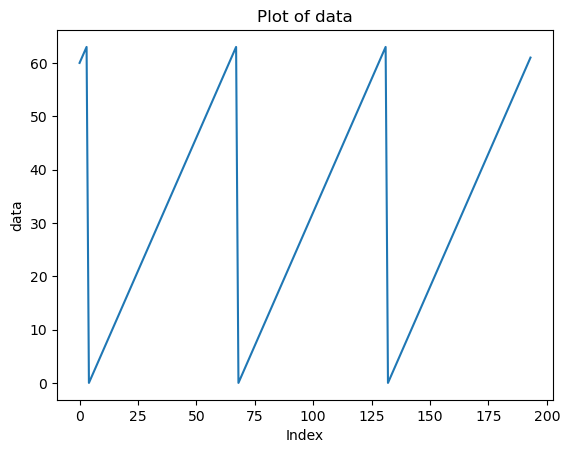

fetching  s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201081713_v7.1.1.cdf


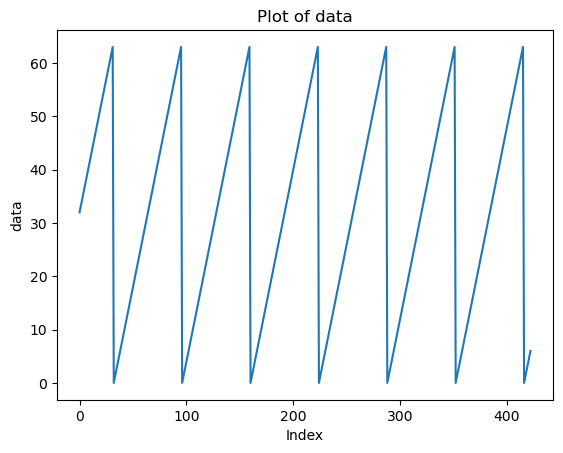

fetching  s3://gov-nasa-hdrl-data1/spdf/cdaweb/data/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201081923_v7.1.1.cdf


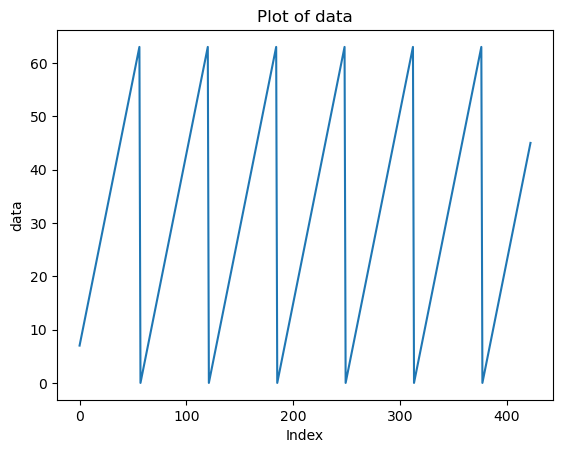

In [74]:
print('# of zVariables | Start Date | File Size')
fr.stream_uri(file_registry1[:3], lambda s3_uri, d, e, f: plot_cdf(s3_uri, d, e, f))

That's it: find a dataset, get a list of files for a given time range, and operate on all the files in bulk.

# Publishing Your Own Dataset

The full spec is in the [cloudcatalog-spec.md](https://github.com/heliocloud-data/cloudcatalog/blob/develop/docs/cloudcatalog-spec.md)

CloudCatalog works for (currently) AWS S3 or anything HTTP/HTTPS.  Here's a tiny example:


```{
    "version": "1.0",
    "name": "My Open Science",
    "egress": "public, no-egress",
    "contact": "Dr. Contact, dr_contact@example.com",
    "description": "Optional description of this collection",
    "citation": "Optional how to cite, preferably a DOI for the server",
    "catalog":[
        {
            "id": "localtest",
            "index": "http://ghostlibrary.com/sampledata/",
            "title": "URL test data",
            "start": "2025-05-01T00:00Z",
            "stop": "2025-06-01T00:00Z",
            "modification": "2025-06-01T00:00Z",
            "indextype": "csv-zip",
            "filetype": "cdf"
        }
    ],
    "status": {
        "code": 1200,
        "message": "OK request successful"
    }
}
```

That points to this directory on the server:
```
sampledata/localtest_2025.csv
sampledata/Ruined_End_Times_Cliff_Top_Wizard_Tower_First_Floor.jpg
sampledata/Ruined_End_Times_Cliff_Top_Wizard_Tower_Second_Floor.jpg
(etc)
```
where that `localtest_2025.csv` file just lists the files available in CloudCatalog format:
```
# start, stop, datakey, filesize
2025-05-08T12:05:30Z,2025-05-08T12:06:14Z,http://ghostlibrary.com/sampledata/Ruined_End_Times_Cliff_Top_Wizard_Tower_First_Floor.jpg,774000
2025-05-09T12:05:30Z,2025-05-09T12:06:14Z,http://ghostlibrary.com/sampledata/Ruined_End_Times_Cliff_Top_Wizard_Tower_Second_Floor.jpg,774000
2025-05-10T12:05:30Z,2025-05-10T12:06:14Z,http://ghostlibrary.com/sampledata/Ruined_End_Times_Cliff_Top_Wizard_Tower_Third_Floor.jpg,774000
2025-05-11T12:05:30Z,2025-05-11T12:06:14Z,http://ghostlibrary.com/sampledata/Ruined_End_Times_Cliff_Top_Wizard_Tower_Fourth_Floor.jpg,774000
```

# Takeaways

CloudCatalog is a PyHC package (`import cloudcatalog`) that gives you access to the 1PB cloud versions of CDAWeb, SDO, MMS, EUV-ML, and other curated datasets.  It is very HAPI-like for users: give it an ID, start and stop and it returns URIs to files.  It also allows self-publishing of datasets.

And like HAPI, it is both a specification and an accompanying Python API.  CloudCatalog is decentralized (data owners control their data) and simply creates a shareable and searchable index.

CloudCatalog for self-publishing datasets requires making a top-level JSON file plus CSV indices, and now you have a lightweight serverless way to provide files via either AWS S3 or conventional web hosting (via direct HTTP or HTTPS URLs).

Bonus: tell HDRL about your top-level JSON file and your data is now indexed and findable by anyone using CloudCatalog.

Future: We'd love to work hook for CloudCatalog calls into other packages (esp. PySpedas and HAPI) so the cloud-stored data is fetchable within user's preferred toolsets.  We are making tools so it is easier for data creators to index their datasets.

# Exercise

pip install cloudcatalog

```
import cloudcatalog
fr = cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")

# Now find a cool CDAWeb dataset, or some SDO AIA data, or similar.
```

# Discussion
https://github.com/heliocloud-data/cloudcatalog